In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
%matplotlib inline

line_markers = ['-.','-,','-o','-v','-^','-<','->','-1','-2','-3','-4','-s','-p','-*','-h','-H','-+','-x','-D','-d','-|','-_']
line_markers = ['*','h','<','4','x','d','|','_']

import sys
sys.path.append('../')
from bayes_layer import BayesianConv2D
from bayes_layer import BayesianLinear
from bayes_layer import _calculate_fan_in_and_fan_out

In [2]:
def avg_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    avg_acc_arr = np.zeros(tasknum)
    for i in range(tasknum):
        avg_acc_arr[i] = np.mean(acc_arr[i][:i+1])
    
    return avg_acc_arr

In [3]:
def test_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    return acc_arr

In [4]:
def forgetting(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum, tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    
    forgetting_arr = np.zeros(tasknum-1)
    for k in range(1,tasknum):
        forgetting_k = np.zeros(k)
        for j in range(k):
            forgetting_k[j] = np.max(acc_arr[:k,j]) - acc_arr[k,j]
        forgetting_arr[k-1] = np.mean(forgetting_k)
    
    return forgetting_arr

# CIFAR10/100

In [5]:
seed_num = 1
UCL = {}
UCL['A'] = {}
UCL['F'] = {}
name = 'NeurIPS_split_cifar10_100_ucl_{}_alpha_0.3_beta_{:.5f}_ratio_{:.4f}_lr_0.001_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'

beta_arr = [2e-3]
ratio_arr = [1/8]
lr_rho_arr = [0.01]

for beta in beta_arr:
    UCL['A'][beta] = {}
    UCL['F'][beta] = {}
    for ratio in ratio_arr:
        UCL['A'][beta][ratio] = {}
        UCL['F'][beta][ratio] = {}
        for lr_rho in lr_rho_arr:
            UCL['A'][beta][ratio][lr_rho] = np.zeros((seed_num, 11))
            UCL['F'][beta][ratio][lr_rho] = np.zeros((seed_num, 10))
            for seed in range(seed_num):
                UCL['A'][beta][ratio][lr_rho][seed] = avg_acc(name.format(seed,beta,ratio,lr_rho), tasknum=11)
                UCL['F'][beta][ratio][lr_rho][seed] = forgetting(name.format(seed,beta,ratio,lr_rho), tasknum=11)

In [6]:
seed_num = 8
EWC = {}
EWC['A'] = {}
EWC['F'] = {}
name = 'NeurIPS_split_cifar10_100_ewc_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [25,50,75,100,250,500,750,1000,2500,5000,7500,10000,25000,50000,75000,100000]
lamb_arr = [25000]
for lamb in lamb_arr:
    EWC['A'][lamb] = np.zeros((seed_num, 11))
    EWC['F'][lamb] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        EWC['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=11)
        EWC['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=11)

In [7]:
seed_num = 8
SI = {}
SI['A'] = {}
SI['F'] = {}
name = 'NeurIPS_split_cifar10_100_si_{}_c_{}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# c_arr = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
c_arr = [0.7]
for c in c_arr:
    SI['A'][c] = np.zeros((seed_num, 11))
    SI['F'][c] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        SI['A'][c][seed] = avg_acc(name.format(seed,c),tasknum=11)
        SI['F'][c][seed] = forgetting(name.format(seed,c),tasknum=11)

In [8]:
seed_num = 8
RWALK = {}
RWALK['A'] = {}
RWALK['F'] = {}

name = 'NeurIPS_split_cifar10_100_rwalk_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lamb_arr = [6]
for lamb in lamb_arr:
    RWALK['A'][lamb] = np.zeros((seed_num, 11))
    RWALK['F'][lamb] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        RWALK['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=11)
        RWALK['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=11)

In [9]:
seed_num = 8
MAS = {}
MAS['A'] = {}
MAS['F'] = {}
name = 'NeurIPS_split_cifar10_100_mas_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2]
lamb_arr = [2.2]
for lamb in lamb_arr:
    MAS['A'][lamb] = np.zeros((seed_num, 11))
    MAS['F'][lamb] = np.zeros((seed_num, 10))
    for seed in range(seed_num):
        MAS['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=11)
        MAS['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=11)

In [10]:
# seed_num = 1
# HAT = {}
# HAT['A'] = {}
# HAT['F'] = {}
# name = 'ICLR_split_cifar10_100_hat_{}_alpha_{}_smax_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# alpha_arr = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 4.0]
# smax_arr = [400, 800]
# for smax in smax_arr:
#     HAT['A'][smax] = {}
#     HAT['F'][smax] = {}
#     for alpha in alpha_arr:
#         HAT['A'][smax][alpha] = np.zeros((seed_num, 11))
#         HAT['F'][smax][alpha] = np.zeros((seed_num, 10))
#         for seed in range(seed_num):
#             HAT['A'][smax][alpha][seed] = avg_acc(name.format(seed,alpha,smax),tasknum=11)
#             HAT['F'][smax][alpha][seed] = forgetting(name.format(seed,alpha,smax),tasknum=11)

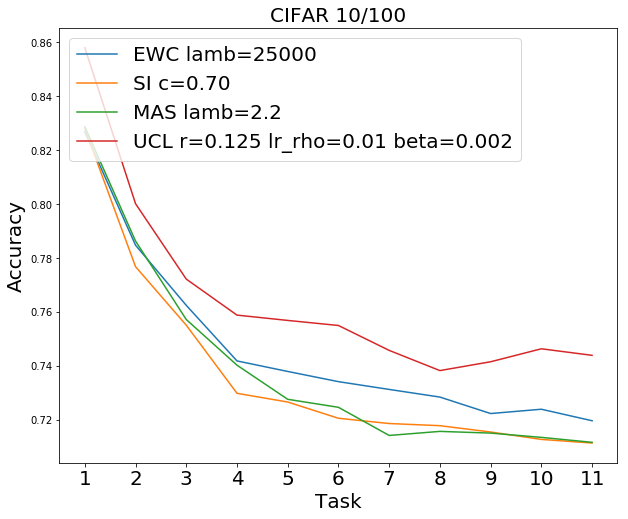

In [11]:
task = np.arange(11) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['A'][25000], axis = 0), linestyle='-', label='EWC lamb=25000')
plt.plot(task, np.mean(SI['A'][0.70], axis = 0), linestyle='-', label='SI c=0.70')
# plt.plot(task, np.mean(RWALK['A'][6], axis = 0), linestyle='-', label='RWALK lamb=6')
plt.plot(task, np.mean(MAS['A'][2.2], axis = 0), linestyle='-', label='MAS lamb=2.2')
plt.plot(task, np.mean(UCL['A'][0.002][0.125][0.01], axis=0), linestyle='-', label='UCL r=0.125 lr_rho=0.01 beta=0.002')
# plt.plot(task, np.mean(HAT['A'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')

plt.xticks([1,2,3,4,5,6,7,8,9,10,11], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.6,0.9)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)


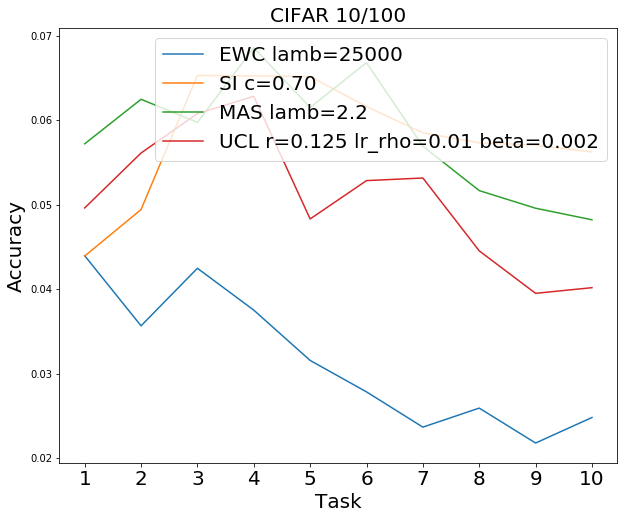

In [12]:
task = np.arange(10) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['F'][25000], axis = 0), linestyle='-', label='EWC lamb=25000')
plt.plot(task, np.mean(SI['F'][0.70], axis = 0), linestyle='-', label='SI c=0.70')
# plt.plot(task, np.mean(RWALK['F'][6], axis = 0), linestyle='-', label='RWALK lamb=6')
plt.plot(task, np.mean(MAS['F'][2.2], axis = 0), linestyle='-', label='MAS lamb=2.2')
plt.plot(task, np.mean(UCL['F'][0.002][0.125][0.01], axis=0), linestyle='-', label='UCL r=0.125 lr_rho=0.01 beta=0.002')
# plt.plot(task, np.mean(HAT['F'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')


plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.6,0.9)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper right', fontsize=20)



# CIFAR 100

In [13]:
seed_num = 1
UCL = {}
UCL['A'] = {}
UCL['F'] = {}
name = 'NeurIPS_split_cifar100_ucl_{}_alpha_5.0_beta_{:.5f}_ratio_{:.4f}_lr_0.001_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'

beta_arr = [2e-4]
ratio_arr = [1/8]
lr_rho_arr = [0.01]

for beta in beta_arr:
    UCL['A'][beta] = {}
    UCL['F'][beta] = {}
    for ratio in ratio_arr:
        UCL['A'][beta][ratio] = {}
        UCL['F'][beta][ratio] = {}
        for lr_rho in lr_rho_arr:
            UCL['A'][beta][ratio][lr_rho] = np.zeros((seed_num, 10))
            UCL['F'][beta][ratio][lr_rho] = np.zeros((seed_num, 9))
            for seed in range(seed_num):
                UCL['A'][beta][ratio][lr_rho][seed] = avg_acc(name.format(seed,beta,ratio,lr_rho), tasknum=10)
                UCL['F'][beta][ratio][lr_rho][seed] = forgetting(name.format(seed,beta,ratio,lr_rho), tasknum=10)

In [14]:
seed_num = 8
EWC = {}
EWC['A'] = {}
EWC['F'] = {}
name = 'NeurIPS_split_cifar100_ewc_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [25,50,75,100,250,500,750,1000,2500,5000,7500,10000, 25000, 50000, 75000, 100000]
lamb_arr = [10000]
for lamb in lamb_arr:
    EWC['A'][lamb] = np.zeros((seed_num, 10))
    EWC['F'][lamb] = np.zeros((seed_num, 9))
    for seed in range(seed_num):
        EWC['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=10)
        EWC['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=10)

In [15]:
seed_num = 8
SI = {}
SI['A'] = {}
SI['F'] = {}
name = 'NeurIPS_split_cifar100_si_{}_c_{}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# c_arr = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
c_arr = [1.0]
for c in c_arr:
    SI['A'][c] = np.zeros((seed_num, 10))
    SI['F'][c] = np.zeros((seed_num, 9))
    for seed in range(seed_num):
        SI['A'][c][seed] = avg_acc(name.format(seed,c),tasknum=10)
        SI['F'][c][seed] = forgetting(name.format(seed,c),tasknum=10)

In [16]:
seed_num = 8
RWALK = {}
RWALK['A'] = {}
RWALK['F'] = {}
name = 'NeurIPS_split_cifar100_rwalk_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lamb_arr = [8]
for lamb in lamb_arr:
    RWALK['A'][lamb] = np.zeros((seed_num, 10))
    RWALK['F'][lamb] = np.zeros((seed_num, 9))
    for seed in range(seed_num):
        RWALK['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=10)
        RWALK['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=10)

In [17]:
seed_num = 8
MAS = {}
MAS['A'] = {}
MAS['F'] = {}
name = 'NeurIPS_split_cifar100_mas_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2]
lamb_arr = [3.2]
for lamb in lamb_arr:
    MAS['A'][lamb] = np.zeros((seed_num, 10))
    MAS['F'][lamb] = np.zeros((seed_num, 9))
    for seed in range(seed_num):
        MAS['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=10)
        MAS['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=10)

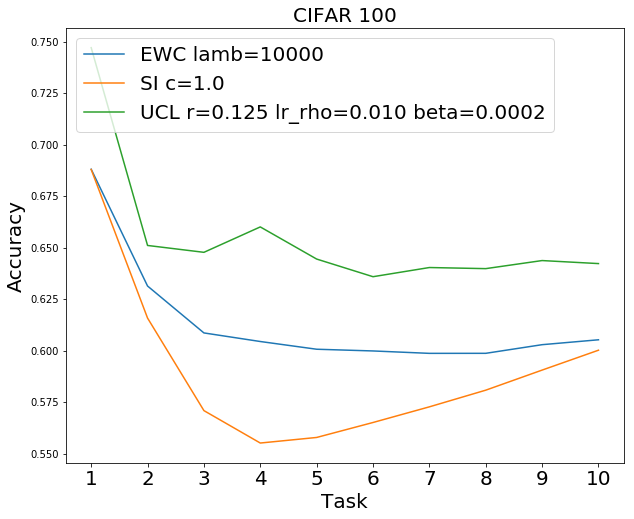

In [18]:
task = np.arange(10) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['A'][10000], axis = 0), linestyle='-', label='EWC lamb=10000')
plt.plot(task, np.mean(SI['A'][1.0], axis = 0), linestyle='-', label='SI c=1.0')
# plt.plot(task, np.mean(RWALK['A'][8], axis = 0), linestyle='-', label='RWALK lamb=8')
# plt.plot(task, np.mean(MAS['A'][3.2], axis = 0), linestyle='-', label='MAS lamb=3.2')
plt.plot(task, np.mean(UCL['A'][0.0002][0.125][0.010], axis=0), linestyle='-', label='UCL r=0.125 lr_rho=0.010 beta=0.0002')
# plt.plot(task, np.mean(HAT['A'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')

plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.6,0.9)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('CIFAR 100', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)



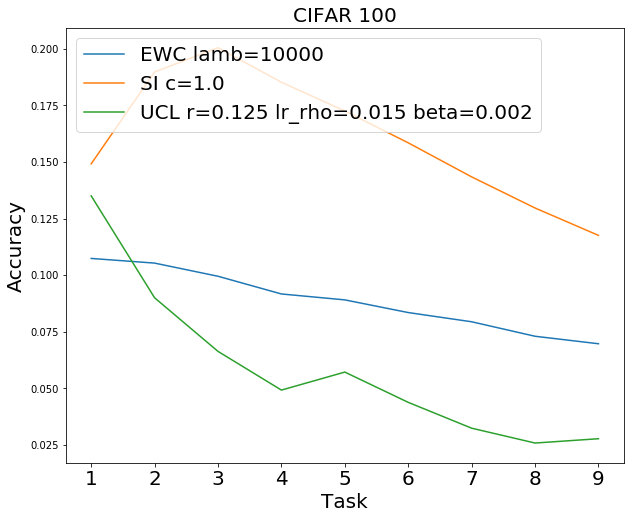

In [19]:
task = np.arange(9) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['F'][10000], axis = 0), linestyle='-', label='EWC lamb=10000')
plt.plot(task, np.mean(SI['F'][1.0], axis = 0), linestyle='-', label='SI c=1.0')
# plt.plot(task, np.mean(RWALK['F'][8], axis = 0), linestyle='-', label='RWALK lamb=8')
# plt.plot(task, np.mean(MAS['F'][3.2], axis = 0), linestyle='-', label='MAS lamb=3.2')
plt.plot(task, np.mean(UCL['F'][0.0002][0.125][0.010], axis=0), linestyle='-', label='UCL r=0.125 lr_rho=0.015 beta=0.002')
# plt.plot(task, np.mean(HAT['F'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')

plt.xticks([1,2,3,4,5,6,7,8,9], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.6,0.9)
# plt.yticks([0.60,0.65,0.70,0.75,0.80,0.85,0.9], fontsize = 20)
plt.title('CIFAR 100', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)




# CIFAR 100 20 tasks

In [20]:
seed_num = 1
UCL = {}
UCL['A'] = {}
UCL['F'] = {}

beta_arr = [1e-4,2e-4,3e-4,4e-4]
ratio_arr = [1/2,1/4,1/8]
lr_rho_arr = [0.005,0.01,0.015,0.02]

name = 'NeurIPS_split_cifar100_20_ucl_{}_alpha_1.0_beta_{:.5f}_ratio_{:.4f}_lr_0.001_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'

for beta in beta_arr:
    UCL['A'][beta] = {}
    UCL['F'][beta] = {}
    for ratio in ratio_arr:
        UCL['A'][beta][ratio] = {}
        UCL['F'][beta][ratio] = {}
        for lr_rho in lr_rho_arr:
            UCL['A'][beta][ratio][lr_rho] = np.zeros((seed_num, 20))
            UCL['F'][beta][ratio][lr_rho] = np.zeros((seed_num, 19))
            for seed in range(seed_num):
                UCL['A'][beta][ratio][lr_rho][seed] = avg_acc(name.format(seed,beta,ratio,lr_rho), tasknum=20)
                UCL['F'][beta][ratio][lr_rho][seed] = forgetting(name.format(seed,beta,ratio,lr_rho), tasknum=20)

In [21]:
seed_num = 1
EWC = {}
EWC['A'] = {}
EWC['F'] = {}
name = 'NeurIPS_split_cifar100_20_ewc_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [25,50,75,100,250,500,750,1000,2500,5000,7500,10000, 25000, 50000, 75000, 100000]
lamb_arr = [25000]
for lamb in lamb_arr:
    EWC['A'][lamb] = np.zeros((seed_num, 20))
    EWC['F'][lamb] = np.zeros((seed_num, 19))
    for seed in range(seed_num):
        EWC['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=20)
        EWC['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=20)

In [22]:
seed_num = 1
SI = {}
SI['A'] = {}
SI['F'] = {}
name = 'NeurIPS_split_cifar100_20_si_{}_c_{}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# c_arr = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
c_arr = [1.0]
for c in c_arr:
    SI['A'][c] = np.zeros((seed_num, 20))
    SI['F'][c] = np.zeros((seed_num, 19))
    for seed in range(seed_num):
        SI['A'][c][seed] = avg_acc(name.format(seed,c),tasknum=20)
        SI['F'][c][seed] = forgetting(name.format(seed,c),tasknum=20)

In [23]:
seed_num = 1
RWALK = {}
RWALK['A'] = {}
RWALK['F'] = {}
name = 'NeurIPS_split_cifar100_20_rwalk_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lamb_arr = [13]
for lamb in lamb_arr:
    RWALK['A'][lamb] = np.zeros((seed_num, 20))
    RWALK['F'][lamb] = np.zeros((seed_num, 19))
    for seed in range(seed_num):
        RWALK['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=20)
        RWALK['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=20)

In [24]:
seed_num = 1
MAS = {}
MAS['A'] = {}
MAS['F'] = {}
name = 'NeurIPS_split_cifar100_20_mas_{}_lamb_{}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2]
lamb_arr = [2.4]
for lamb in lamb_arr:
    MAS['A'][lamb] = np.zeros((seed_num, 20))
    MAS['F'][lamb] = np.zeros((seed_num, 19))
    for seed in range(seed_num):
        MAS['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=20)
        MAS['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=20)

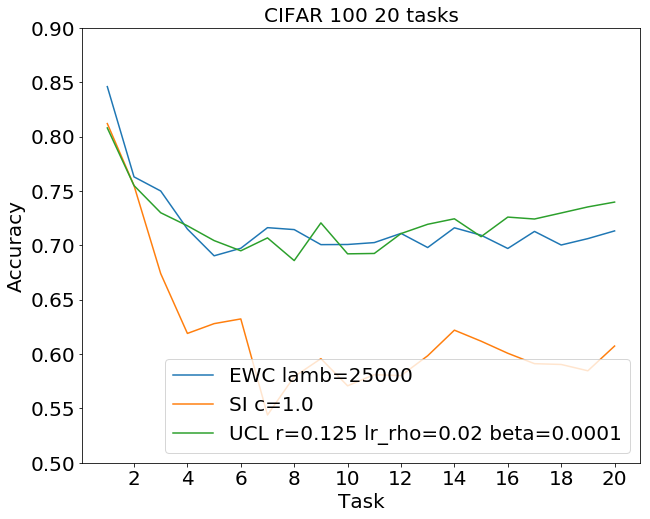

In [25]:
task = np.arange(20) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['A'][25000], axis = 0), linestyle='-', label='EWC lamb=25000')
plt.plot(task, np.mean(SI['A'][1.0], axis = 0), linestyle='-', label='SI c=1.0')
# plt.plot(task, np.mean(RWALK['A'][13], axis = 0), linestyle='-', label='RWALK lamb=13')
# plt.plot(task, np.mean(MAS['A'][2.4], axis = 0), linestyle='-', label='MAS lamb=2.4')
plt.plot(task, np.mean(UCL['A'][1e-4][1/8][0.02], axis=0), linestyle='-', label='UCL r=0.125 lr_rho=0.02 beta=0.0001')
# plt.plot(task, np.mean(HAT['A'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')

plt.xticks([2,4,6,8,10,12,14,16,18,20], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim(0.50,0.90)
plt.yticks([0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90], fontsize = 20)
plt.title('CIFAR 100 20 tasks', fontsize = 20)
plt.legend(loc = 'lower right', fontsize=20)


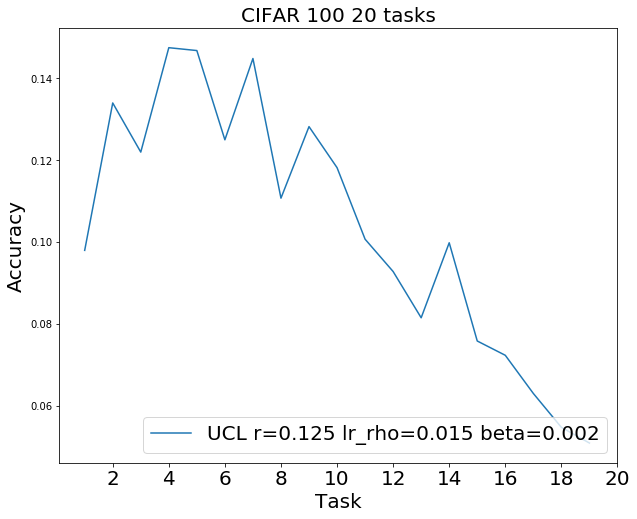

In [26]:
task = np.arange(19) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
# plt.plot(task, np.mean(EWC['F'][25000], axis = 0), linestyle='-', label='EWC lamb=25000')
# plt.plot(task, np.mean(SI['F'][1.0], axis = 0), linestyle='-', label='SI c=1.0')
# plt.plot(task, np.mean(RWALK['F'][13], axis = 0), linestyle='-', label='RWALK lamb=13')
# plt.plot(task, np.mean(MAS['F'][2.4], axis = 0), linestyle='-', label='MAS lamb=2.4')
plt.plot(task, np.mean(UCL['F'][1e-4][1/8][0.02], axis=0), linestyle='-', label='UCL r=0.125 lr_rho=0.015 beta=0.002')
# plt.plot(task, np.mean(HAT['F'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')


plt.xticks([2,4,6,8,10,12,14,16,18,20], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.50,0.90)
# plt.yticks([0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90], fontsize = 20)
plt.title('CIFAR 100 20 tasks', fontsize = 20)
plt.legend(loc = 'lower right', fontsize=20)



# Omniglot

In [27]:
seed_num = 1
UCL = {}
UCL['A'] = {}
UCL['F'] = {}

name = 'NeurIPS_omniglot_ucl_{}_alpha_5.0_beta_{:.5f}_ratio_{:.4f}_lr_0.001_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'
beta_arr = [1e-5]
ratio_arr = [1/2]
lr_rho_arr = [0.015]

for beta in beta_arr:
    UCL['A'][beta] = {}
    UCL['F'][beta] = {}
    for ratio in ratio_arr:
        UCL['A'][beta][ratio] = {}
        UCL['F'][beta][ratio] = {}
        for lr_rho in lr_rho_arr:
            UCL['A'][beta][ratio][lr_rho] = np.zeros((seed_num, 50))
            UCL['F'][beta][ratio][lr_rho] = np.zeros((seed_num, 49))
            for seed in range(seed_num):
                UCL['A'][beta][ratio][lr_rho][seed] = avg_acc(name.format(seed,beta,ratio,lr_rho), tasknum=50)
                UCL['F'][beta][ratio][lr_rho][seed] = forgetting(name.format(seed,beta,ratio,lr_rho), tasknum=50)

In [28]:
seed_num = 8
EWC = {}
EWC['A'] = {}
EWC['F'] = {}
name = 'NeurIPS_omniglot_ewc_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [25,50,75,100,250,500,750,1000,2500,5000,7500,10000,25000,50000,75000,100000]
lamb_arr = [100000]
for lamb in lamb_arr:
    EWC['A'][lamb] = np.zeros((seed_num, 50))
    EWC['F'][lamb] = np.zeros((seed_num, 49))
    for seed in range(seed_num):
        EWC['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=50)
        EWC['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=50)

In [29]:
seed_num = 8
SI = {}
SI['A'] = {}
SI['F'] = {}
name = 'NeurIPS_omniglot_si_{}_c_{}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# c_arr = [0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
c_arr = [1.0]
for c in c_arr:
    SI['A'][c] = np.zeros((seed_num, 50))
    SI['F'][c] = np.zeros((seed_num, 49))
    for seed in range(seed_num):
        SI['A'][c][seed] = avg_acc(name.format(seed,c),tasknum=50)
        SI['F'][c][seed] = forgetting(name.format(seed,c),tasknum=50)

In [30]:
seed_num = 1
RWALK = {}
RWALK['A'] = {}
RWALK['F'] = {}
name = 'NeurIPS_omniglot_rwalk_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
# lamb_arr = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
lamb_arr = [15]
for lamb in lamb_arr:
    RWALK['A'][lamb] = np.zeros((seed_num, 50))
    RWALK['F'][lamb] = np.zeros((seed_num, 49))
    for seed in range(seed_num):
        RWALK['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=50)
        RWALK['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=50)

In [31]:
seed_num = 1
MAS = {}
MAS['A'] = {}
MAS['F'] = {}
name = 'NeurIPS_omniglot_mas_{}_lamb_{:.1f}_lr_0.001_unitN_400_batch_256_epoch_100_conv.txt'
lamb_arr = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2]
for lamb in lamb_arr:
    MAS['A'][lamb] = np.zeros((seed_num, 50))
    MAS['F'][lamb] = np.zeros((seed_num, 49))
    for seed in range(seed_num):
        MAS['A'][lamb][seed] = avg_acc(name.format(seed,lamb),tasknum=50)
        MAS['F'][lamb][seed] = forgetting(name.format(seed,lamb),tasknum=50)

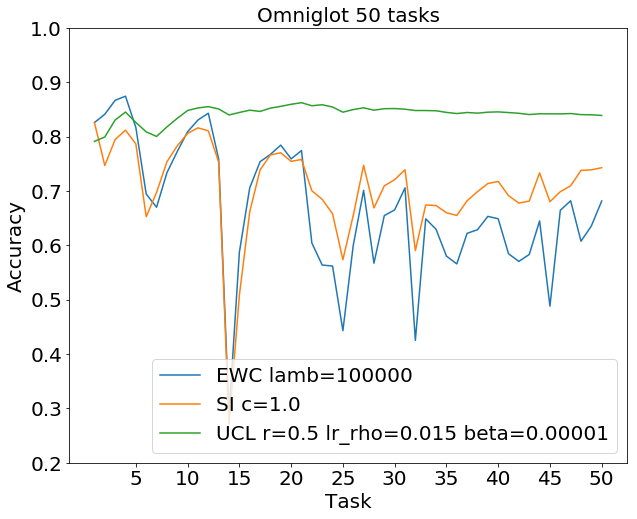

In [32]:
task = np.arange(50) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['A'][100000], axis = 0), linestyle='-', label='EWC lamb=100000')
plt.plot(task, np.mean(SI['A'][1.0], axis = 0), linestyle='-', label='SI c=1.0')
# plt.plot(task, np.mean(RWALK['A'][15], axis = 0), linestyle='-', label='RWALK lamb=15')
# plt.plot(task, np.mean(MAS['A'][2.6], axis = 0), linestyle='-', label='MAS lamb=2.6')
plt.plot(task, np.mean(UCL['A'][1e-5][1/2][0.015], axis=0), linestyle='-', label='UCL r=0.5 lr_rho=0.015 beta=0.00001')
# plt.plot(task, np.mean(HAT['A'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')

# beta_arr = [1e-5]
# ratio_arr = [1/2]
# lr_rho_arr = [0.005,0.01,0.015,0.02]

# res = np.zeros(4)

# for beta in beta_arr:
#     for ratio in ratio_arr:
#         for i,lr_rho in enumerate(lr_rho_arr):
#             res[i] = np.mean(UCL['A'][beta][ratio][lr_rho], axis=0)[-1]
#             plt.plot(task, np.mean(UCL['A'][beta][ratio][lr_rho], axis=0), linestyle='-', label='UCL r=0.5 lr_rho=%.3f beta=0.00001'%lr_rho)


# print(np.max(res))
# print(np.argmax(res))
plt.xticks([5,10,15,20,25,30,35,40,45,50], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim(0.20,1.00)
plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize = 20)
plt.title('Omniglot 50 tasks', fontsize = 20)
plt.legend(loc = 'lower right', fontsize=20)


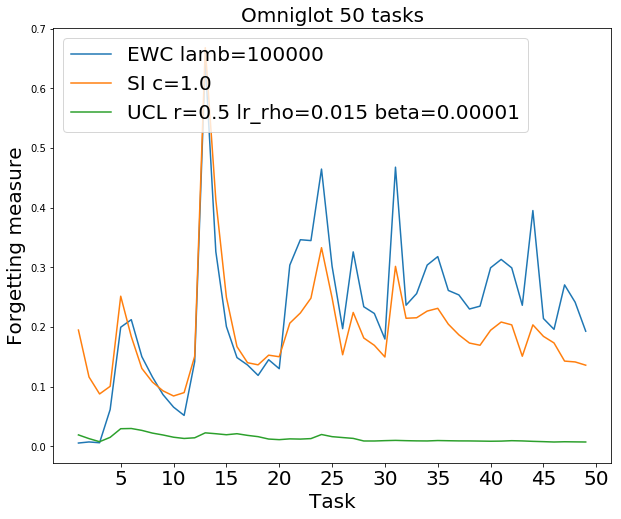

In [33]:
task = np.arange(49) + 1

plt.figure(figsize=(10,8))

# plt.errorbar(task, np.mean(EWC[1000], axis = 0), np.std(EWC[1000], axis = 0), linestyle='-', label='EWC lamb=1000')
plt.plot(task, np.mean(EWC['F'][100000], axis = 0), linestyle='-', label='EWC lamb=100000')
plt.plot(task, np.mean(SI['F'][1.0], axis = 0), linestyle='-', label='SI c=1.0')
# plt.plot(task, np.mean(RWALK['F'][15], axis = 0), linestyle='-', label='RWALK lamb=15')
# plt.plot(task, np.mean(MAS['F'][2.6], axis = 0), linestyle='-', label='MAS lamb=2.6')
plt.plot(task, np.mean(UCL['F'][1e-5][1/2][0.015], axis=0), linestyle='-', label='UCL r=0.5 lr_rho=0.015 beta=0.00001')
# plt.plot(task, np.mean(HAT['A'][800][0.1], axis = 0), linestyle='-', label='HAT smax=800 alpha=0.1')



plt.xticks([5,10,15,20,25,30,35,40,45,50], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Forgetting measure', fontsize=20)
# plt.ylim(0.20,1.00)
# plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize = 20)
plt.title('Omniglot 50 tasks', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)



# Ablation Study

In [34]:
seed_num = 5
UCL = {}
UCL['A'] = {}
UCL['F'] = {}
UCL['T'] = {}

beta_arr = [1e-2,1.5e-2,2e-2,2.5e-2,3e-2,3.5e-2,4e-2,4.5e-2]
ablation_arr = ['None','no_L1','no_upper','no_lower','no_sigma_normal']
# ablation_arr = ['None','no_L1','no_upper','no_lower']
name = 'prev_results/NeurIPS_ablation_pmnist_ucl_ablation_{}_{}_alpha_0.01_beta_{:.5f}_ratio_0.5000_lr_0.001_lr_rho_0.001_unitN_400_batch_256_epoch_100.txt'
for ablation in ablation_arr:
    UCL['A'][ablation] = {}
    UCL['F'][ablation] = {}
    UCL['T'][ablation] = {}
    for beta in beta_arr:
        UCL['A'][ablation][beta] = np.zeros((seed_num,10))
        UCL['F'][ablation][beta] = np.zeros((seed_num,9))
        UCL['T'][ablation][beta] = np.zeros((seed_num, 10, 10))
        for seed in range(seed_num):
            try:
                UCL['A'][ablation][beta][seed] = avg_acc(name.format(seed,ablation, beta), tasknum=10)
                UCL['F'][ablation][beta][seed] = forgetting(name.format(seed,ablation, beta), tasknum=10)
                UCL['T'][ablation][beta][seed] = test_acc(name.format(seed,ablation, beta), tasknum=10)
            except:
                print('CUDA_VISIBLE_DEVICES={} python3 main.py --experiment pmnist --seed {} --approach ucl_ablation --date NeurIPS_ablation --tasknum 10 --ablation {} --beta {:.4f} --ratio 0.5 &'.format(0,seed,ablation,beta))
                
                

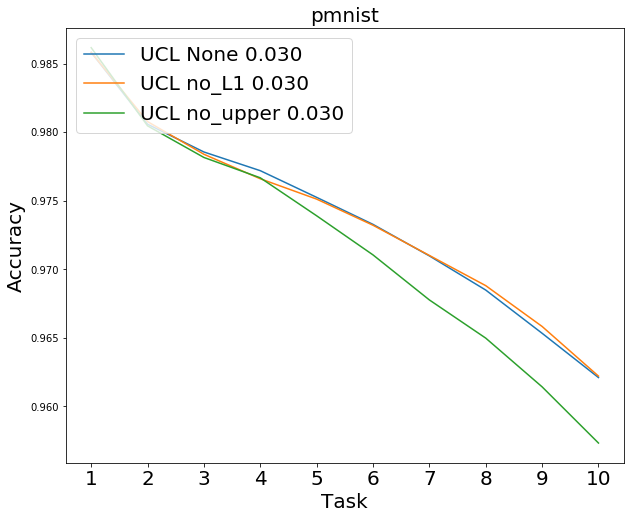

In [35]:
task = np.arange(10) + 1

plt.figure(figsize=(10,8))

hyper_arr = [
    (0.030,'None'),
    (0.030,'no_L1'),
    (0.030,'no_upper'),
    (0.03,'no_lower'),
    (0.03,'no_sigma_normal')
]

# for beta, ablation in hyper_arr:
#     plt.plot(task, np.mean(UCL['A'][ablation][beta], axis=0), linestyle='-', label='UCL %s %.3f'%(ablation, beta))

beta_arr = [
#     1e-2,
#     1.5e-2,
#     2e-2,
#     2.5e-2,
    3e-2,
#     3.5e-2,
#     4e-2,
#     4.5e-2
]
ablation_arr = [
    'None',
    'no_L1',
    'no_upper',
#     'no_lower',
#     'no_sigma_normal'
]

for ablation in ablation_arr:
    for beta in beta_arr:
        plt.plot(task, np.mean(UCL['A'][ablation][beta], axis=0), linestyle='-', label='UCL %s %.3f'%(ablation, beta))

plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.20,1.00)
# plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize = 20)
plt.title('pmnist', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)



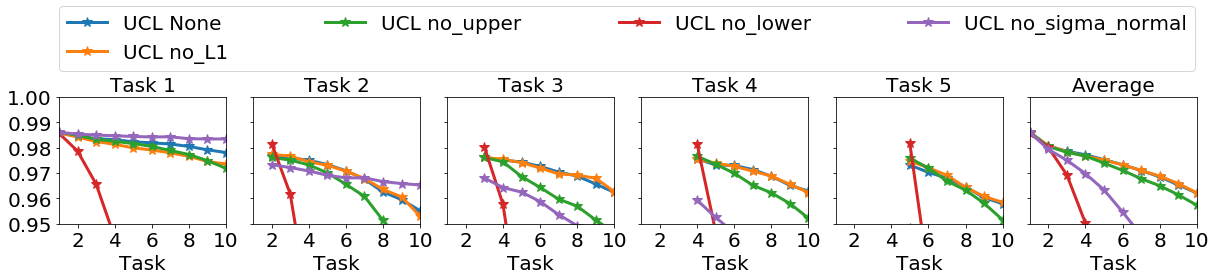

In [36]:
task = np.arange(10)+1

plt.figure(figsize = (17,4))
for i in range(5):
    plt.subplot(1,6,i+1)
    
    for beta, ablation in hyper_arr:
        plt.plot(task[i:], np.mean(UCL['T'][ablation][beta], axis=0)[i:,i], label='UCL %s'%(ablation), linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
    
    plt.xlim(1,10)
    plt.xticks([2,4,6,8,10], fontsize = 20)
    plt.ylim(0.95,1.0)
    if i==0:
        plt.legend(bbox_to_anchor=(0, 1.2, 6.8,.102), loc=3, ncol=4, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
    visible = True
    if i>0:
        visible=False
    plt.ylim(0.95,1.0)
    plt.yticks([0.95,0.96,0.97,0.98,0.99,1.0], fontsize = 20, visible=visible)
    plt.xlabel('Task', fontsize=20)
    plt.title('Task %d'%(i+1), fontsize = 20)
    plt.tight_layout()
    

plt.subplot(1,6,6)
for beta, ablation in hyper_arr:
    plt.plot(task, np.mean(UCL['A'][ablation][beta], axis=0), label='UCL %s'%(ablation), linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)

plt.xlim(1,10)
plt.xticks([2,4,6,8,10], fontsize = 20)
plt.ylim(0.95,1.0)
plt.yticks([0.95,0.96,0.97,0.98,0.99,1.0], fontsize = 20, visible=visible)
plt.title('Average', fontsize = 20)
plt.xlabel('Task',fontsize = 20)

plt.tight_layout()
# plt.savefig('figure/Ablation_PMNIST_per_task_avg.pdf', bbox_inches='tight')

In [58]:
seed_num = 8
UCL = {}
UCL['A'] = {}
UCL['F'] = {}
UCL['T'] = {}


beta_arr = [1e-2,2e-2,3e-2,4e-2]
ablation_arr = ['None','no_L1','no_upper','no_lower','no_sigma_normal']
name = 'NeurIPS_ablation_row_pmnist_ucl_ablation_{}_{}_alpha_0.01_beta_{:.5f}_ratio_0.5000_lr_0.001_lr_rho_0.001_unitN_400_batch_256_epoch_100.txt'
for ablation in ablation_arr:
    UCL['A'][ablation] = {}
    UCL['F'][ablation] = {}
    UCL['T'][ablation] = {}
    for beta in beta_arr:
        UCL['A'][ablation][beta] = np.zeros((seed_num,10))
        UCL['F'][ablation][beta] = np.zeros((seed_num,9))
        UCL['T'][ablation][beta] = np.zeros((seed_num, 10, 10))
        for seed in range(seed_num):
            try:
                UCL['A'][ablation][beta][seed] = avg_acc(name.format(seed,ablation, beta), tasknum=10)
                UCL['F'][ablation][beta][seed] = forgetting(name.format(seed,ablation, beta), tasknum=10)
                UCL['T'][ablation][beta][seed] = test_acc(name.format(seed,ablation, beta), tasknum=10)
            except:
                print('CUDA_VISIBLE_DEVICES={} python3 main.py --experiment pmnist --seed {} --approach ucl_ablation --date NeurIPS_ablation --tasknum 10 --ablation {} --beta {:.4f} --ratio 0.5 &'.format(0,seed,ablation,beta))
                
                

[0.9859     0.97556875 0.9648375  0.95011563 0.9284     0.90398333
 0.88879464 0.86980313 0.86040417 0.85122   ]


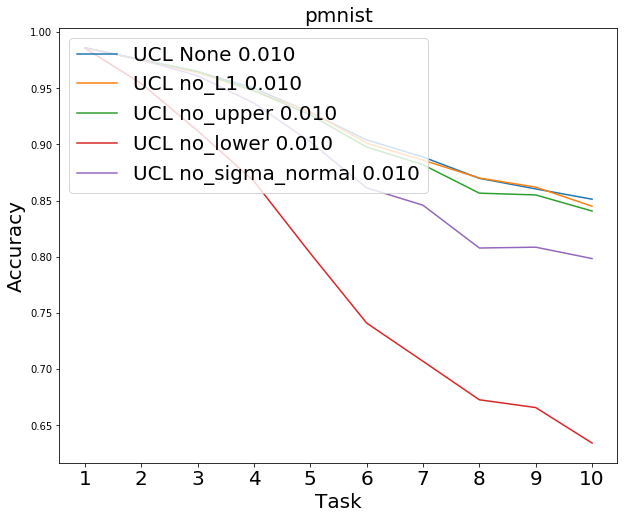

In [62]:
task = np.arange(10) + 1

plt.figure(figsize=(10,8))

hyper_arr = [
    (0.01,'None'),
    (0.01,'no_L1'),
    (0.01,'no_upper'),
    (0.01,'no_lower'),
    (0.01,'no_sigma_normal')
]

# for beta, ablation in hyper_arr:
#     plt.plot(task, np.mean(UCL['A'][ablation][beta], axis=0), linestyle='-', label='UCL %s %.3f'%(ablation, beta))
    


beta_arr = [
    1e-2,
#     2e-2,
#     3e-2,
#     4e-2,
]
ablation_arr = [
    'None',
    'no_L1',
    'no_upper',
    'no_lower',
    'no_sigma_normal'
]

for ablation in ablation_arr:
    for beta in beta_arr:
        plt.plot(task, np.mean(UCL['A'][ablation][beta], axis=0), linestyle='-', label='UCL %s %.3f'%(ablation, beta))

plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.20,1.00)
# plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize = 20)
plt.title('pmnist', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)

print(np.mean(UCL['A']['None'][1e-2], axis=0))


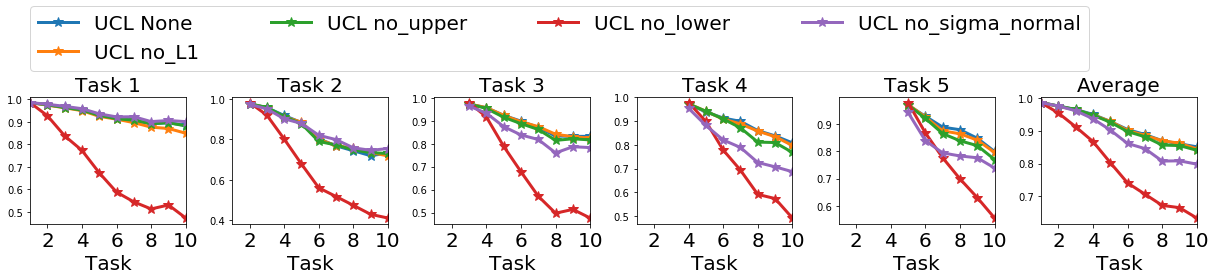

In [63]:
task = np.arange(10)+1

plt.figure(figsize = (17,4))
for i in range(5):
    plt.subplot(1,6,i+1)
    
    for beta, ablation in hyper_arr:
        plt.plot(task[i:], np.mean(UCL['T'][ablation][beta], axis=0)[i:,i], label='UCL %s'%(ablation), linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
    
    plt.xlim(1,10)
    plt.xticks([2,4,6,8,10], fontsize = 20)
#     plt.ylim(0.95,1.0)
    if i==0:
        plt.legend(bbox_to_anchor=(0, 1.2, 6.8,.102), loc=3, ncol=4, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
    visible = True
    if i>0:
        visible=False
#     plt.ylim(0.95,1.0)
#     plt.yticks([0.95,0.96,0.97,0.98,0.99,1.0], fontsize = 20, visible=visible)
    plt.xlabel('Task', fontsize=20)
    plt.title('Task %d'%(i+1), fontsize = 20)
    plt.tight_layout()
    

plt.subplot(1,6,6)
for beta, ablation in hyper_arr:
    plt.plot(task, np.mean(UCL['A'][ablation][beta], axis=0), label='UCL %s'%(ablation), linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)

plt.xlim(1,10)
plt.xticks([2,4,6,8,10], fontsize = 20)
# plt.ylim(0.95,1.0)
# plt.yticks([0.95,0.96,0.97,0.98,0.99,1.0], fontsize = 20, visible=visible)
plt.title('Average', fontsize = 20)
plt.xlabel('Task',fontsize = 20)

plt.tight_layout()
# plt.savefig('figure/Ablation_PMNIST_per_task_avg.pdf', bbox_inches='tight')

In [39]:
seed_num = 8
UCL = {}
UCL['A'] = {}
UCL['F'] = {}
UCL['T'] = {}

beta_arr = [1e-3,2e-3,3e-3,4e-3]
lr_rho_arr = [0.01]
# lr_rho_arr = [0.015]
ablation_arr = ['None','no_L1','no_upper','no_lower','no_sigma_normal']

name = 'NeurIPS_ablation_split_cifar10_100_ucl_ablation_{}_{}_alpha_0.3_beta_{:.5f}_ratio_0.1250_lr_0.001_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'
for ablation in ablation_arr:
    UCL['A'][ablation] = {}
    UCL['F'][ablation] = {}
    UCL['T'][ablation] = {}
    for beta in beta_arr:
        UCL['A'][ablation][beta] = {}
        UCL['F'][ablation][beta] = {}
        UCL['T'][ablation][beta] = {}
        for lr_rho in lr_rho_arr:
            UCL['A'][ablation][beta][lr_rho] = np.zeros((seed_num,11))
            UCL['F'][ablation][beta][lr_rho] = np.zeros((seed_num,10))
            UCL['T'][ablation][beta][lr_rho] = np.zeros((seed_num,11,11))
            for seed in range(seed_num):
                try:
                    UCL['A'][ablation][beta][lr_rho][seed] = avg_acc(name.format(seed,ablation,beta,lr_rho), tasknum=11)
                    UCL['F'][ablation][beta][lr_rho][seed] = forgetting(name.format(seed,ablation,beta,lr_rho), tasknum=11)
                    UCL['T'][ablation][beta][lr_rho][seed] = test_acc(name.format(seed,ablation,beta,lr_rho), tasknum=11)
                except:
                    print('CUDA_VISIBLE_DEVICES={} python3 main.py --experiment split_cifar10_100 --seed {} --approach ucl_ablation --date NeurIPS_ablation --alpha 0.3 --conv-net --ablation {} --beta {:.4f} --ratio 0.125 --lr_rho 0.01 &'.format(0,seed,ablation,beta))
                
                

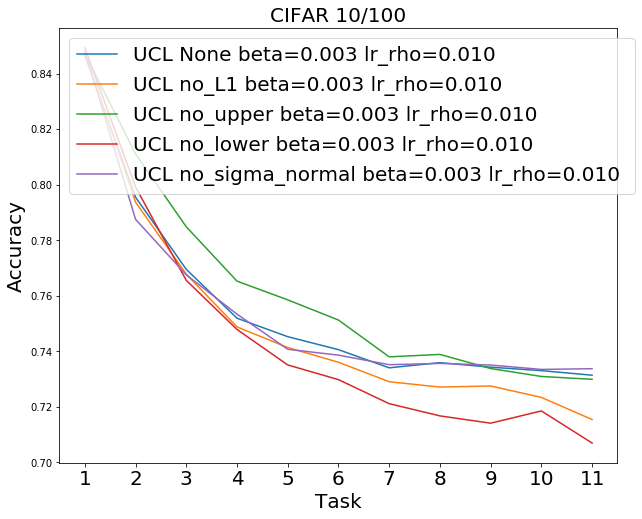

In [40]:
task = np.arange(11) + 1

plt.figure(figsize=(10,8))

hyper_arr = [
    (0.003,0.01,'None'),
    (0.003,0.01,'no_L1'),
    (0.003,0.01,'no_upper'),
    (0.003,0.01,'no_lower'),
    (0.003,0.01,'no_sigma_normal')
]


# for beta,lr_rho,ablation in hyper_arr:
#     plt.plot(task, np.mean(UCL['A'][ablation][beta][lr_rho], axis=0), linestyle='-', label='UCL %s beta=%.3f lr_rho=%.3f '%(ablation, beta, lr_rho))

# plt.figure(figsize=(10,8))
# task = np.arange(10) + 1
# for beta,lr_rho,ablation in hyper_arr:
#     plt.plot(task, np.mean(UCL['F'][ablation][beta][lr_rho], axis=0), linestyle='-', label='UCL %s beta=%.3f lr_rho=%.3f '%(ablation, beta, lr_rho))
    
beta_arr = [
#     1e-3,
#     2e-3,
    3e-3,
#     4e-3
]
lr_rho_arr = [
    0.01,
#     0.015
]
ablation_arr = [
    'None',
    'no_L1',
    'no_upper',
    'no_lower',
    'no_sigma_normal'
]

for ablation in ablation_arr:
    for lr_rho in lr_rho_arr:
        for beta in beta_arr:
            plt.plot(task, np.mean(UCL['A'][ablation][beta][lr_rho], axis=0), linestyle='-', label='UCL %s beta=%.3f lr_rho=%.3f '%(ablation, beta, lr_rho))

plt.xticks([1,2,3,4,5,6,7,8,9,10,11], fontsize = 20)

plt.xlabel('Task', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
# plt.ylim(0.72,0.76)
# plt.yticks([0.72,0.73,0.74,0.75,0.76], fontsize = 20)
plt.title('CIFAR 10/100', fontsize = 20)
plt.legend(loc = 'upper left', fontsize=20)



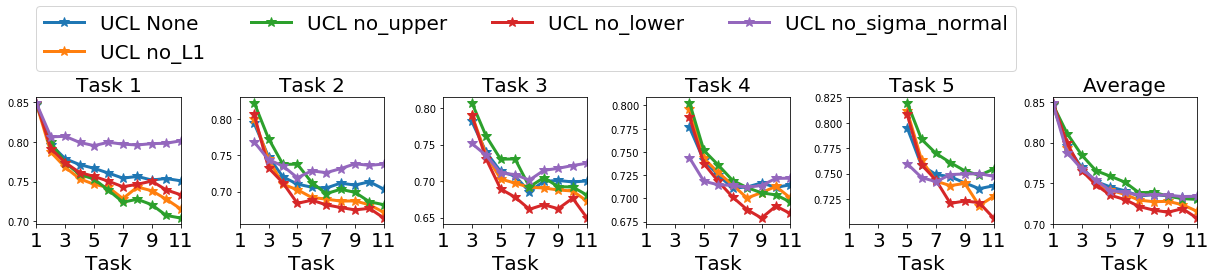

In [41]:
task = np.arange(11)+1

plt.figure(figsize = (17,4))
for i in range(5):
    plt.subplot(1,6,i+1)
    
    for beta,lr_rho,ablation in hyper_arr:
        plt.plot(task[i:], np.mean(UCL['T'][ablation][beta][lr_rho], axis=0)[i:,i], label='UCL %s'%(ablation), linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
    
    plt.xlim(1,11)
    plt.xticks([1,3,5,7,9,11], fontsize = 20)
#     plt.ylim(0.95,1.0)
    if i==0:
        plt.legend(bbox_to_anchor=(0, 1.2, 6.8,.102), loc=3, ncol=4, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
    visible = True
    if i>0:
        visible=False
#     plt.ylim(0.95,1.0)
#     plt.yticks([0.95,0.96,0.97,0.98,0.99,1.0], fontsize = 20, visible=visible)
    plt.xlabel('Task', fontsize=20)
    plt.title('Task %d'%(i+1), fontsize = 20)
    plt.tight_layout()
    

plt.subplot(1,6,6)
for beta,lr_rho,ablation in hyper_arr:
    plt.plot(task, np.mean(UCL['A'][ablation][beta][lr_rho], axis=0), label='UCL %s'%(ablation), linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)

plt.xlim(1,11)
plt.xticks([1,3,5,7,9,11], fontsize = 20)
# plt.ylim(0.95,1.0)
# plt.yticks([0.95,0.96,0.97,0.98,0.99,1.0], fontsize = 20, visible=visible)
plt.title('Average', fontsize = 20)
plt.xlabel('Task',fontsize = 20)

plt.tight_layout()
# plt.savefig('figure/Ablation_PMNIST_per_task_avg.pdf', bbox_inches='tight')

# 8 sequence of vision dataset

# Alpha test

In [42]:
# UCL['A'] = {}
# name = 'prev_results/ALPHA_split_cifar100_20_ucl_1_alpha_{:.1f}_beta_0.00010_ratio_0.2500_lr_0.001_lr_rho_{}_unitN_400_batch_256_epoch_100_conv.txt'
# alpha_arr = np.arange(60) / 10 + 0.1
# lr_rho_arr = [0.01,0.02]

# for lr_rho in lr_rho_arr:
#     UCL['A'][lr_rho] = np.zeros(60)
#     for i,alpha in enumerate(alpha_arr):
#         UCL['A'][lr_rho][i] = avg_acc(name.format(alpha,lr_rho), tasknum=20)[0]


In [43]:
# plt.plot(alpha_arr, UCL['A'][0.02], label='lr_rho = 0.02')

# print(np.max(UCL['A'][0.02]))
# print(np.argmax(UCL['A'][0.01]))
# print(np.argmax(UCL['A'][0.02]))

In [44]:
# UCL['A'] = {}
# name = 'prev_results/ALPHA_omniglot_ucl_0_alpha_{:.1f}_beta_0.00010_ratio_{:.4f}_lr_0.001_lr_rho_0.01_unitN_400_batch_256_epoch_100_conv.txt'
# alpha_arr = np.arange(60) / 10 + 0.1

# ratio_arr = [1/4,1/8,1/16]

# for ratio in ratio_arr:
#     UCL['A'][ratio] = np.zeros(60)
#     for i,alpha in enumerate(alpha_arr):
#         UCL['A'][ratio][i] = avg_acc(name.format(alpha,ratio), tasknum=50)[0]


In [45]:
# plt.figure(figsize=(10,8))
# plt.plot(alpha_arr, UCL['A'][1/4], label='ratio = 1/4')
# plt.plot(alpha_arr, UCL['A'][1/8], label='ratio = 1/8')
# plt.plot(alpha_arr, UCL['A'][1/16], label='ratio = 1/16')

# plt.legend(loc='lower right', fontsize = 20)

# print(np.max(UCL['A'][1/8]))
# print(np.argmax(UCL['A'][1/8]))
